In [343]:
#Convertendo o banco de dados em uma lista da seguinte forma:
#data = [número da linha , Nome/Identificador , paralaxe, Mag U , Mag B , Mag V , Mag R , Mag I , Tipo spectral]
data_0 = open('data_SIMBAD_2.txt','r')
data_1=[]
data=[]
for i in data_0:
  i=i.rstrip().split('|')
  for j in i:
    j=j.replace(' ','')
    data_1.append(j)
  data.append(data_1)
  data_1=[]

#Posição dos parametros na lista referente ao banco de dados com as estrelas
posplx=2
posmv=5
posmb=4
postipospc=8

#Convertendo para lista, uma tabela de referência para estrelas da sequência principal
# data_seqprinc = [ Tipo spectral(Todos da seq principal), temperatura efetiva, log(Teff), Correção Bolmetrica em v, log(luminosidade), MagBolometrica, R/Rsol, Mag em V, B-V, Massa/Massasol]
data_seqprinc=[]
ms=open('tabela_mainseq.txt','r')
for i in ms:
  i=i.rstrip().split(' ')
  data_seqprinc.append(i)

In [349]:
from prompt_toolkit.application.application import Input

import numpy as np
import math 
#magnitudes de Vega nas respectivas bandas de frequência
Vega={ 'U':4.175*1e-08,	'B': 6.32*1e-08,'V':	3.631*1e-08,'R':	2.177*1e-08,'I':1.126*1e-08	}
#Função que retorna a magnitude da estela
#Parâmetros: Fluxo em (W^-1  m^−2  µm^−1) e Banda de frequência (string)
#Exemplo : magnitude(0.02*1e-08 , 'V')
def magnitude(fluxo,freq):
  if fluxo!='~':
    flx=float(fluxo)/float(Vega[freq])
    mag= -2.5*(math.log(flx,10))
    return mag
  else:
    return 0
#Solicitando os parâmetros ao usuário
s=input('Informe o Fluxo "f" ou a magnitude "m"(Digite f ou m)')
print('Caso não tenha o parâmetro solicitado responda "~"')
if s=='f':
  Fv=float(input('Valor do fluxo em V: '))
  Fb=float(input('Valor do fluxo em B: '))
  plx=float(input('Paralaxe: '))
  mv=magnitude(Fv,'V')
  mb=magnitude(Fb,'B')
elif s=='m':
  mv=float(input('Valor da magnitude em V: '))
  mb=float(input('Valor da magnitude em B: '))
  plx=float(input('Paralaxe: '))
else:
  print('Erro')

Informe o Fluxo "f" ou a magnitude "m"(Digite f ou m)m
Caso não tenha o parâmetro solicitado responda "~"
Valor da magnitude em V: 9.97
Valor da magnitude em B: 10.49
Paralaxe: 5.9692


In [350]:

#Função que realiza a consulta no banco de dados retornando uma lista das estrelas que correspondem ao valor fornecido
#Parâmetros : parâmetro que deseja filtrar, posição desse parâmetro na tabela, banco de dados a ser consultado, eroo tolerado para a medida
#Exemplo: consulta(plx,1,data,0.02,'float')
def consultafloat(param,pos,dados,erro):
  selecionados=[]
  for i in dados:
    if i[pos]!='~':
      if float(i[pos])-erro < param < float(i[pos])+erro:
        selecionados.append(i)
  return selecionados

def consultastring(param,dados):
  selec=[]
  for t in dados:
    if t[0]==param:
      selec.append(t)
  return selec
#Consultando o banco de dados com a paralaxe, e colocando as estrelas selecionadas na lista : "estrelas0"
estrelas0=consultafloat(plx,posplx,data,0.0001)
#Caso mais de uma estrela for selecionada, verificar o banco de dados com a Magnitude em V
if len(estrelas0)>1:
  estrelas1=consultafloat(mv,posmv,estrelas0,0.01)
  #Se ainda restar mais de uma estrela, verificar com a Magnitude em B
  if len(estrelas1)>1:
    estrelas2=consultafloat(mb,posmb,estrelas1,0.01)
    estrelafinal=estrelas2[0]
  else:
    estrelafinal=estrelas1[0]
else:
  estrelafinal=estrelas0[0]
#'estrelafinal' contem os dados da estrela procuarada
nome=estrelafinal[1]
tipospect=estrelafinal[8]
#Algumas estrelas possuem outras especificações no tipo espectral, que não serão usadas neste programa Ex : B9.5VCrEuSi
#Reduzir o tipo espectral com apenas as informações utilizadas Ex : B9.5VCrEuSi -> B9.5V
c=tipospect.find('V')
tipospect=tipospect[:c+1]


In [351]:
#Agora consultando a tabela de referencias para estrelas da sequencia principal

teff=float((consultastring(tipospect,data_seqprinc))[0][1])
logteff=float(consultastring(tipospect,data_seqprinc)[0][2])
BCv=float(consultastring(tipospect,data_seqprinc)[0][3])
logLum=float(consultastring(tipospect,data_seqprinc)[0][4])
Magbol=float(consultastring(tipospect,data_seqprinc)[0][5])
R_Rsol=float(consultastring(tipospect,data_seqprinc)[0][6])
MagV=float(consultastring(tipospect,data_seqprinc)[0][7])
B_V=float(consultastring(tipospect,data_seqprinc)[0][8])
M_Msol=float(consultastring(tipospect,data_seqprinc)[0][9])

#Função que retorna o tempo restante para a estrela na sequência principal(m= massa da estrela em massas solares, L=log da luminosidade/Lsol na base 10)
def temponuclear(m,L):
  #calcular a energia que pode ser produzida no núcleo da estrela
  #10% da massa da estrela no nucleo
  #0.7% da massa dos protons convertidas em energia(E=mc^2)
  Msol=1.9*pow(10,30)
  Lsol=3.9*pow(10,26)

  Lum=pow(10,L)*Lsol
  en=0.0007*(m*Msol)*(pow(3*(10**8),2))
  #O tempo restante da estrela na sequencia principal pode ser aproximado pelo tempo nuclear(em segundos)
  tnuclear=en/Lum
  tnuclear=tnuclear/(3600*24*356)

  return tnuclear/10**6
  
#Funcao que retorna os parametros em RGB da aproximacao da cor emitida pela estrela
def cor(temp):
  #Parametro vermelho da cor(0-255)
  r=temp/100
  if r<=60:
    r=255
  else:
    r= r-60
    r= 329.7*(pow(r,-0.13))
    if r<0:
      r=0
    if r>255:
      r=255
  #Parametro verde (0-255)
  g=temp/100
  if g<=66:
    g= (99.5 * np.log(g)) - 161.1
  else:
    g= 288.1*(pow(g,-0.075))
    if g<0:
      g=0
    if g>255:
      g=255
  #Parametro azul (0-255)
  b=temp/100
  if b>=66:
    b=255
  else:
    if b<=19:
      b=0
    else:
      b= b-10
      b=(138.5* np.log(b)) - 305
      if b<0:
        b=0
      if b>255:
        b=255
  #Passando os valores de 0-255 para 0-1
  return r/255,g/255,b/255


#Função para deteminar como será o fim da evolucao da estrela
def finalevol(m):
  if m >25:
    return 'se tornar um Buraco Negro'
  elif 8<m<=25:
    return 'explodir como uma Supernova e formar uma Estrela de Neutrôns'
  elif 0.45<m<=8:
    return 'se tornar uma anã branca de C/O'
  elif 0.08<=m<=0.45:
    return 'se tornar uma anã branca de He'





In [352]:
#São exibidos os parâmetros calculados anteriormente
print('Estrela procurada :',nome)
print('====================================================')
print('Dados da estrela :')
print('----------------------------------------------------')
print('Temperatura(K)=',teff,'(%.2f temperaturas solares)'%(teff/5772))
print('----------------------------------------------------')
print('Tipo spectral : ',tipospect)
print('----------------------------------------------------')
print('Luminosidade(em luminosidades solares)=%.1f'%pow(10,logLum))
print('----------------------------------------------------')
print('Massa(Massa solares)=',M_Msol)
print('----------------------------------------------------')
print('Raio(em raios solares)=%.3f'%R_Rsol)
print('----------------------------------------------------')
print('Magnitude em V=',MagV)
print('----------------------------------------------------')
print('Correção bolométrica',BCv)
print('----------------------------------------------------')
print('Índice de cor(B-V)=',B_V)
print('----------------------------------------------------')
print('Essa estrela vai deixar a sequência principal em %.0f milhões de anos'%(temponuclear(M_Msol,(pow(10,logLum)))))
print('----------------------------------------------------')
print('Ao fim de sua evolução essa estrela vai',finalevol(M_Msol))
print('====================================================')

Estrela procurada : HD218349
Dados da estrela :
----------------------------------------------------
Temperatura(K)= 6280.0 (1.09 temperaturas solares)
----------------------------------------------------
Tipo spectral :  F7V
----------------------------------------------------
Luminosidade(em luminosidades solares)=2.5
----------------------------------------------------
Massa(Massa solares)= 1.21
----------------------------------------------------
Raio(em raios solares)=1.324
----------------------------------------------------
Magnitude em V= 3.8
----------------------------------------------------
Correção bolométrica -0.035
----------------------------------------------------
Índice de cor(B-V)= 0.5
----------------------------------------------------
Essa estrela vai deixar a sequência principal em 42 milhões de anos
----------------------------------------------------
Ao fim de sua evolução essa estrela vai se tornar uma anã branca de C/O


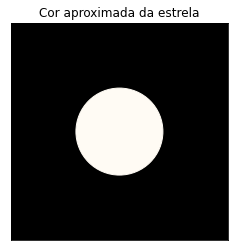

In [353]:
#Conforme a função 'cor', é exibida a cor aproximada da estrela
import matplotlib.pyplot as plt
figure, axes = plt.subplots()
C=cor(teff)
cor = plt.Circle(( 0.5, 0.5 ), 0.2 ,color=(C))
 
axes.set_aspect( 1 )
axes.add_artist(cor)
axes.set_facecolor('black')
axes.set_xticks([])
axes.set_yticks([])
plt.title( 'Cor aproximada da estrela' )

plt.show()

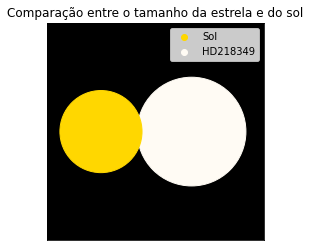

In [354]:
#Comparando o tamanho das estrelas
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
R_estrela=10*R_Rsol
#Ajustando a proporção da imagem para diferentes relações entre os raios
xy=R_estrela*4
if R_estrela>=10:
  xy=R_estrela*4
  xsol=xy/4
  xest=xy/1.5
else:
  xy=10*4
  xest=xy/4
  xsol=xy/1.5
sol = plt.Circle(( xsol, xy/2 ), 10 ,color='gold')
ax.scatter(xsol,xy/2,color='gold',label='Sol')

estrela= plt.Circle((xest, xy/2 ), R_estrela ,color=(C))
ax.scatter(xest, xy/2 ,color=(C),label=nome)

ax.legend()

ax.set(xlim=(0,xy),
         ylim=(0,xy))
ax.set_aspect( 1 )
ax.set_facecolor('black')
ax.add_artist(estrela)
ax.add_artist(sol)
ax.set_xticks([])
ax.set_yticks([])
plt.title( 'Comparação entre o tamanho da estrela e do sol' )

plt.show()

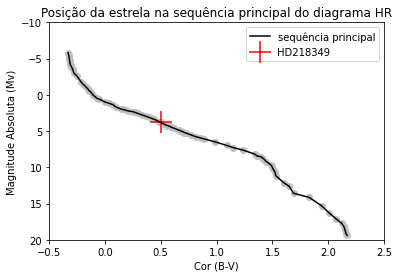

In [355]:
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
#Plotando todos os tipos spectrais na sequencia principal para referencia
fig, ax = plt.subplots()
xseq=[]
yseq=[]
for p in data_seqprinc:
  xseq.append(float(p[8]))
  yseq.append(float(p[7]))
  ax.scatter(float(p[8]),float(p[7]),c='silver')
#Calculando a função polinomial que aproxima a sequencia principal
fseq=interp1d(xseq,yseq,kind='cubic')
plt.plot(xseq,fseq(xseq),'-',color='black',label='sequência principal')
#Plotando a estrela no grafico
ax.scatter(B_V,MagV,c='r',s=500,label=nome,marker='+')

ax.set(xlim=(-0.5, 2.5),
       ylim=(20, -10))
ax.set_xlabel('Cor (B-V)')
ax.set_ylabel('Magnitude Absoluta (Mv)')
ax.set_title('Posição da estrela na sequência principal do diagrama HR')
ax.legend()
plt.show()